In [137]:
library(tidyverse)
library(plotly)
library(maps)
library(rbokeh)
library(widgetframe)
library(htmlwidgets)

# For text analysis
library(tm)
library(SnowballC)
library(wordcloud)
library(tidytext)

Warning message:
“package ‘tidytext’ was built under R version 3.4.4”

## **Convert the tables to dataframes**

In [2]:
con = dbConnect(drv = RSQLite::SQLite(), dbname = "database.sqlite")
tables <- dbListTables(con)
tables <- tables[tables != "sqlite_sequence"]
lDataFrames <- vector("list", length = length(tables))
for (i in seq(along=tables)) {
  lDataFrames[[i]] <- dbGetQuery(conn = con, statement = paste("SELECT * FROM '", tables[[i]], "'", sep=""))
}

## **Overview of each dataframe**

In [7]:
df1 <- as_tibble(lDataFrames[[1]])

In [8]:
head(df1)

row_names,game.id,game.type,details.description,details.image,details.maxplayers,details.maxplaytime,details.minage,details.minplayers,details.minplaytime,⋯,stats.family.arcade.bayesaverage,stats.family.arcade.pos,stats.family.atarist.bayesaverage,stats.family.atarist.pos,stats.family.commodore64.bayesaverage,stats.family.commodore64.pos,stats.subtype.rpgitem.bayesaverage,stats.subtype.rpgitem.pos,stats.subtype.videogame.bayesaverage,stats.subtype.videogame.pos
1,1,boardgame,"Die Macher is a game about seven sequential political races in different regions of Germany. Players are in charge of national political parties, and must manage limited resources to help their party to victory. The winning party will have the most victory points after all the regional elections. There are four different ways of scoring victory points. First, each regional election can supply one to eighty victory points, depending on the size of the region and how well your party does in it. Second, if a party wins a regional election and has some media influence in the region, then the party will receive some media-control victory points. Third, each party has a national party membership which will grow as the game progresses and this will supply a fair number of victory points. Lastly, parties score some victory points if their party platform matches the national opinions at the end of the game.&#10;&#10;The 1986 edition featured 4 parties from the old West Germany and supported 3-4 players. The 1997 edition supports up to 5 players in the re-united Germany and updated several features of the rules as well. The 2006 edition also supports up to 5 players and adds a shorter 5 round variant and additional rules updates by the original designer.&#10;&#10;Die Macher is #1 in the Valley Games Classic Line&#10;&#10;",//cf.geekdo-images.com/images/pic159509.jpg,5,240,14,3,240,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,2,boardgame,"Dragonmaster is a trick-taking card game based on an older game called Coup d'etat. Each player is given a supply of plastic gems, which represent points. Each player will get to be the dealer for five different hands, with slightly different goals for each hand. After all cards have been dealt out, the dealer decides which hand best suits his or her current cards, and the other players are penalized points (in the form of crystals) for taking certain tricks or cards. For instance, if &quot;first&quot; or &quot;last&quot; is called, then a player is penalized for taking the first or last tricks. All players will get a chance to be dealer for five hands, but other players can steal this opportunity by taking all of the tricks during certain hands. At the end, the biggest pile of gems wins the game.&#10;&#10;Jewel contents:&#10;&#10;11 clear (3 extra)&#10;13 green (1 extra)&#10;22 red (2 extra)&#10;22 blue (2 extra)&#10;&#10;",//cf.geekdo-images.com/images/pic184174.jpg,4,30,12,3,30,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,3,boardgame,"Part of the Knizia tile-laying trilogy, Samurai is set in medieval Japan. Players compete to gain the favor of three factions: samurai, peasants, and priests, which are represented by helmet, rice paddy, and Buddha tokens scattered about the board, which features the islands of Japan. The competition is waged through the use of hexagonal tiles, each of which help curry favor of one of the three factions &mdash; or all three at once! Players can make lightning-quick strikes with horseback ronin and ships or approach their conquests more methodically. As each token (helmets, rice paddies, and Buddhas) is surrounded, it is awarded to the player who has gained the most favor with the corresponding group.&#10;&#10;Gameplay continues until all the symbols of one type have been removed from the board or four tokens have been removed from play due to a tie for influence.&#10;&#10;At the end of the game, players compare captured symbols of each type, competing for majorities in each of the three types. Ties are not uncommon and 

There seem to be lot of NA values. Lets look at them

In [9]:
count_of_na_values <- apply(df1, 2, function(x) sum(is.na(x)))
count_of_na_values

row_names 
                                       0 
                                 game.id 
                                       0 
                               game.type 
                                       0 
                     details.description 
                                       0 
                           details.image 
                                    6892 
                      details.maxplayers 
                                       3 
                     details.maxplaytime 
                                       3 
                          details.minage 
                                       3 
                      details.minplayers 
                                       3 
                     details.minplaytime 
                                       3 
                            details.name 
                                       0 
                     details.playingtime 
                                       3 
                       details.thumbnail 
                                    6892 
                   details.yearpublished 
                                       3 
              attributes.boardgameartist 
                                   55735 
            attributes.boardgamecategory 
                                    1531 
         attributes.boardgamecompilation 
                                   88105 
            attributes.boardgamedesigner 
                                   11883 
           attributes.boardgameexpansion 
                                   72613 
              attributes.boardgamefamily 
                                   40232 
      attributes.boardgameimplementation 
                                   85712 
         attributes.boardgameintegration 
                                   89116 
            attributes.boardgamemechanic 
                                   15237 
           attributes.boardgamepublisher 
                                      95 
                        attributes.total 
                                       0 
                           stats.average 
                                       0 
                     stats.averageweight 
                                       0 
                      stats.bayesaverage 
                                       0 
     stats.family.abstracts.bayesaverage 
                                   89503 
              stats.family.abstracts.pos 
                                   89542 
           stats.family.cgs.bayesaverage 
                                   90058 
                    stats.family.cgs.pos 
                                   90136 
stats.family.childrensgames.bayesaverage 
                                   89721 
         stats.family.childrensgames.pos 
                                   89730 
   stats.family.familygames.bayesaverage 
                                   88688 
            stats.family.familygames.pos 
                                   88842 
    stats.family.partygames.bayesaverage 
                                   89924 
             stats.family.partygames.pos 
                                   89964 
 stats.family.strategygames.bayesaverage 
                                   88398 
          stats.family.strategygames.pos 
                                   88769 
      stats.family.thematic.bayesaverage 
                                   89273 
               stats.family.thematic.pos 
                                   89530 
      stats.family.wargames.bayesaverage 
                                   87364 
               stats.family.wargames.pos 
                                   87870 
                            stats.median 
                                       0 
                       stats.numcomments 
                                       0 
                        stats.numweights 
                                       0 
                             stats.owned 
                                       0 

Wow! A lot of NA values. Before analysing the variables, lets select the most important for our analysis.

In [10]:
columns_to_keep <- c("game.id", "game.type", "details.description", "details.maxplayers", "details.maxplaytime",
                     "details.minage", "details.minplayers", "details.minplaytime", "details.minplaytime",
                     "details.name", "details.playingtime", "details.yearpublished")
df2 <- select(df1, columns_to_keep)
dim(df2)

[1] 90400    11

In [11]:
head(lDataFrames[[5]])

row_names,game.id,game.type,details.maxplayers,details.maxplaytime,details.minage,details.minplayers,details.minplaytime,details.name,details.playingtime,⋯,attributes.t.links.concat.2....,stats.subtype.rpgitem.bayesaverage,stats.subtype.rpgitem.pos,stats.weight.factor,details.playingtime.factor,details.minplayers.factor,details.maxplayers.factor,details.minage.factor,stats.average.factor,topic
1,1,boardgame,5,240,14,3,240,Die Macher,240,⋯,NA,NA,NA,4,240+,3,5,14,"[7.00,9.83]",Monopoly-inspired
2,2,boardgame,4,30,12,3,30,Dragonmaster,30,⋯,NA,NA,NA,2,30,3,4,12,"[6.40,7.00)",Traditional Card Games
3,3,boardgame,4,60,10,2,30,Samurai,60,⋯,NA,NA,NA,3,60,2,4,10,"[7.00,9.83]",Area Control Games
4,4,boardgame,4,60,12,2,60,Tal der Könige,60,⋯,NA,NA,NA,3,60,2,4,12,"[6.40,7.00)",Corporate Strategy Games
5,5,boardgame,6,90,12,3,90,Acquire,90,⋯,NA,NA,NA,3,90,3,6,12,"[7.00,9.83]",Corporate Strategy Games
6,6,boardgame,6,240,12,2,240,Mare Mediterraneum,240,⋯,NA,NA,NA,3,240+,2,6,12,"[6.40,7.00)",Area Control Games


We see that the last table is the same as the first one except it also contains the topic on which the board game is based. I will use this column also for my exploratory analysis. Let us join the 2 tables

In [12]:
df3 <- lDataFrames[[5]] %>%
select(c("game.id", "topic"))

df <- merge(df2, df3, by = "game.id", all.x = TRUE)

Now that we have removed our unimportant variables (we will return to some of them afterwards), lets begin the exploratory analysis

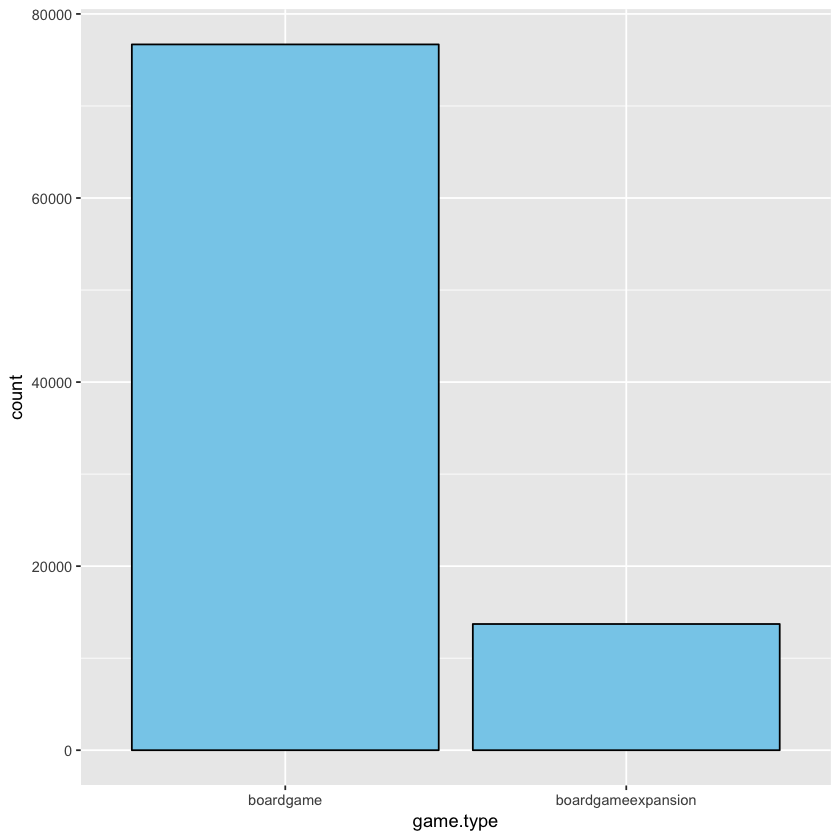

In [13]:
df %>%
ggplot(aes(game.type))+
geom_bar(fill = "skyblue", color = "black")

Apart from boardgames we also have expansions of these board-games.

## **Maximum players in a game**

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 54 rows containing non-finite values (stat_bin).”

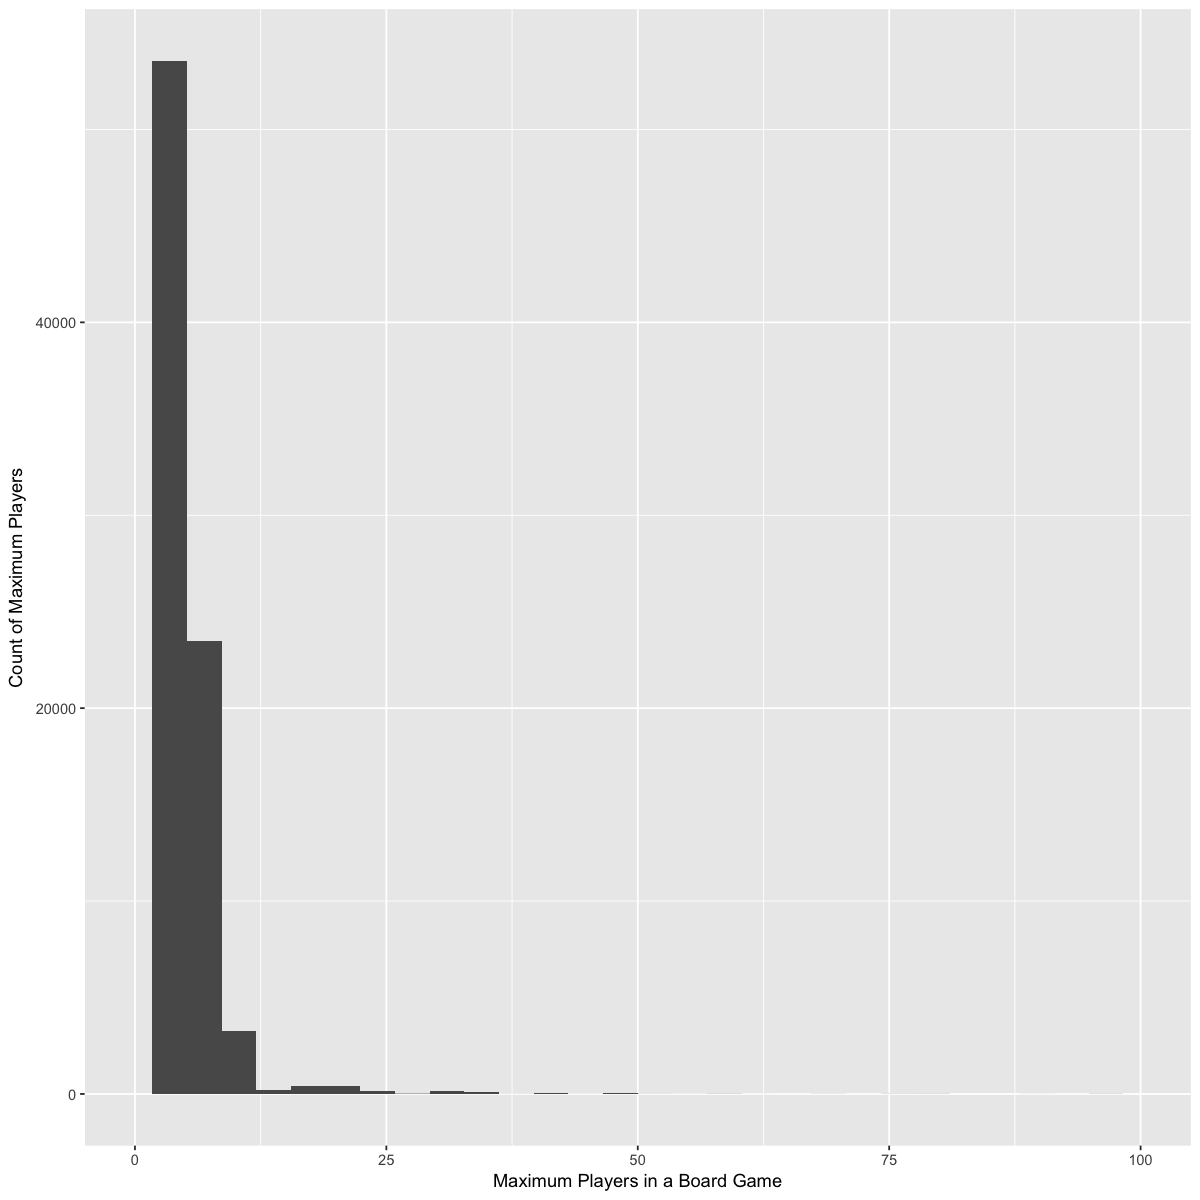

In [67]:
options(repr.plot.width = 10, repr.plot.height = 10)

df %>%
ggplot(aes(details.maxplayers))+
geom_histogram()+
xlim(0, 100)+
labs(x = "Maximum Players in a Board Game", y = "Count of Maximum Players")

Woah! Obviously most of the board games will have very few players...ranging from 2 - 10. But what we see above that there are some board games which have maximum players near to 100. Lets look at which games are these.

Adding missing grouping variables: `details.maxplayers`


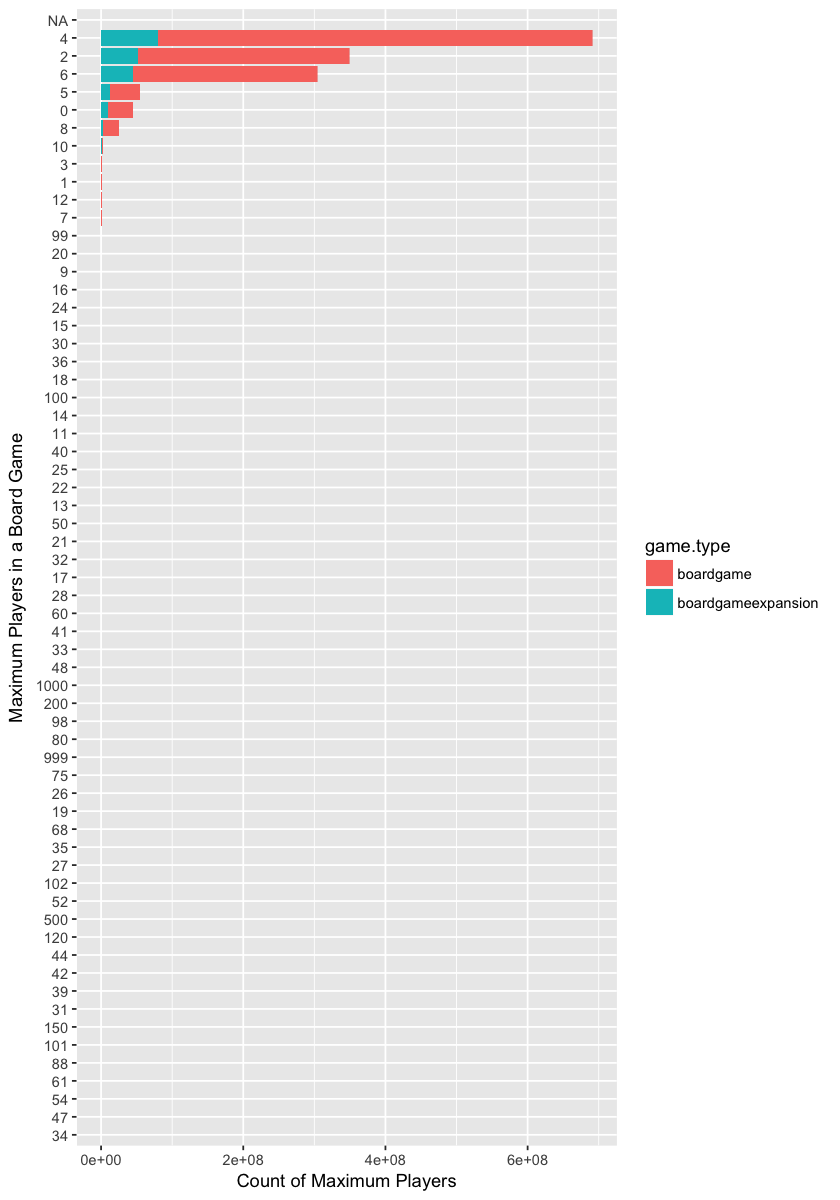

In [93]:
options(repr.plot.width = 7, repr.plot.height = 10)

# df %>%
# count(details.maxplayers) %>%
# filter(!is.na(details.maxplayers)) %>%
# filter(n > 1) %>%
# ggplot(aes(reorder(as.ordered(details.maxplayers), n), n))+
# geom_bar(stat = "identity")+
# labs(x = "Maximum Players in a Board Game", y = "Count of Maximum Players")+
# coord_flip()

df %>%
group_by(details.maxplayers) %>%
mutate(
    count_of_players = length(details.maxplayers),
) %>%
select(c("count_of_players", "game.type")) %>%
filter(count_of_players > 1) %>%
ggplot(aes(reorder(as.ordered(details.maxplayers), count_of_players), count_of_players))+
geom_bar(aes(fill = game.type), stat = "identity")+
labs(x = "Maximum Players in a Board Game", y = "Count of Maximum Players")+
coord_flip()

So we see that the maximum board games involve 4 maximum players followed by games having 2 maximum players.

In [84]:
df %>%
filter(details.maxplayers == 100) %>%
.$details.name

[1] "Word Trek"                                                                            
 [2] "Complete Music Quiz Night In"                                                         
 [3] "Prawo Dżungli: dodatek"                                                               
 [4] "Spin-O"                                                                               
 [5] "Jetpack Unicorn"                                                                      
 [6] "Birthday Gamesake"                                                                    
 [7] "Over The Line"                                                                        
 [8] "Fairy Meat: Clockwork Stomp"                                                          
 [9] "Music Rocks"                                                                          
[10] "Haggle"                                                                               
[11] "FLIP MMCG"                                                                            
[12] "Casino Slots"                                                                         
[13] "7-Spot Yott"                                                                          
[14] "Scooby Doo Story Telling Dice"                                                        
[15] "Naval Action: A Simple Combat Resolution System for Model Fleets of the 1898-1945 Era"
[16] "Ultra Quick Wrestling"                                                                
[17] "Out of ConTXT"                                                                        
[18] "Värvet: Det Sociala Spelet"                                                           
[19] "Fairy Meat: Wicked Things"                                                            
[20] "Jam Dudel"                                                                            
[21] "They're at the Post"                                                                  
[22] "The Muldoon Game"                                                                     
[23] "Canada First Quiz"                                                                    
[24] "Hailstorm"                                                                            
[25] "Minigolf"                                                                             
[26] "Let's Get Sh*t-Faced"                                                                 
[27] "Dicewords"                                                                            
[28] "The Con Game"                                                                         
[29] "Mister Whiskers and the Wrigleybottom Jewel Robbery"                                  
[30] "Rapid Recall"                                                                         
[31] "What the F*ck?"                                                                       
[32] "Chuck-A-Luck"                                                                         
[33] "MasterMinds and Monkey-Shines"                                                        
[34] "Prawo Dżungli"                                                                        
[35] "Karmas"                                                                               
[36] "They're At The Post"                                                                  
[37] "Lumps, the Game of Big Rolls and Smart Holds"                                         
[38] "Awethors"                                                                             
[39] "Hi-Bol"                                                                               
[40] "Flip-'n-Stack Tiki Island"                                                            
[41] "Fairy Meat"                                                                           
[42] "Purse & Pockets Plus"                                                                 
[43] "Tänkolär"                                                                             
[4

The above games are those that allow 100 maximum players.

## **Maximum playtime**
Lets look at what is the normal playtime of games

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 3 rows containing missing values (geom_bar).”

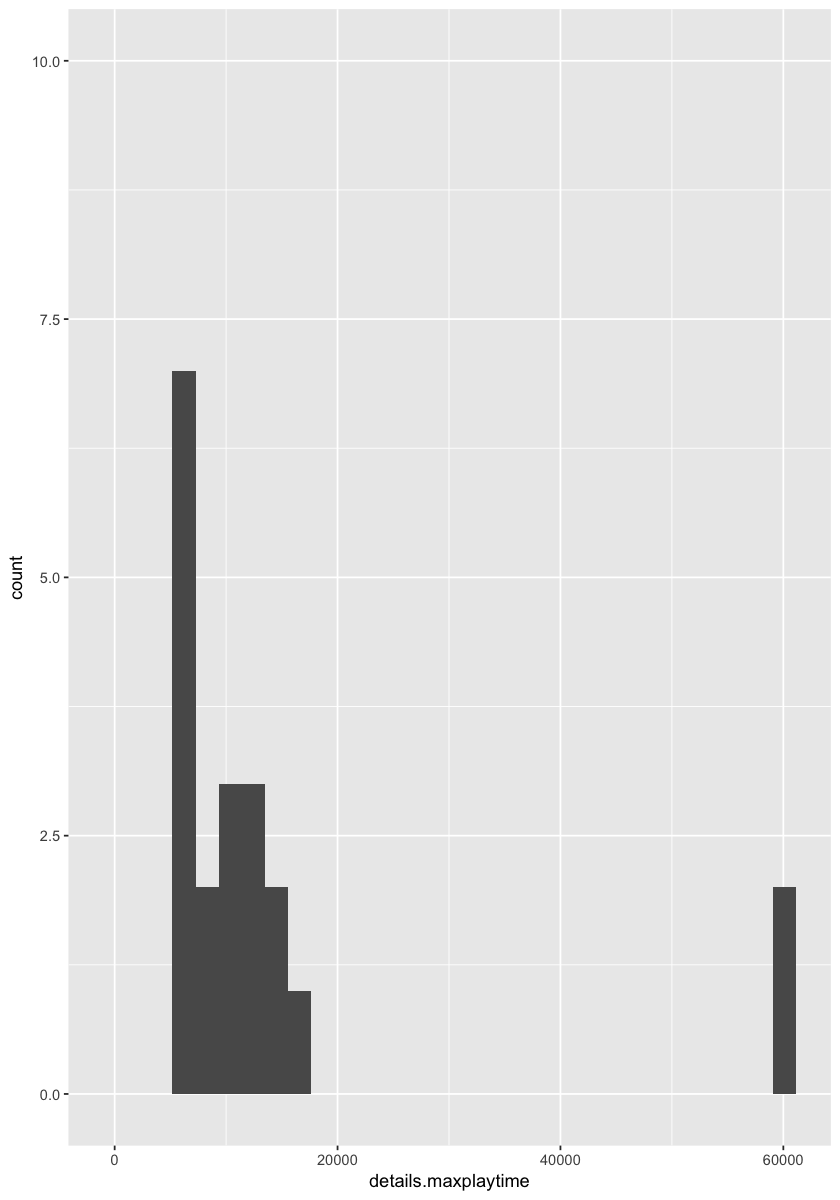

In [108]:
df %>%
filter(details.maxplaytime > 0) %>%
ggplot(aes(details.maxplaytime))+
geom_histogram()+
ylim(0, 10)

So we see that there are some games with a maximum playtime of 60,000 minutes! I think this may be an error in data collection. Lets look at the distribution in detail.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 119 rows containing non-finite values (stat_bin).”Warning message:
“Removed 17 rows containing missing values (geom_bar).”

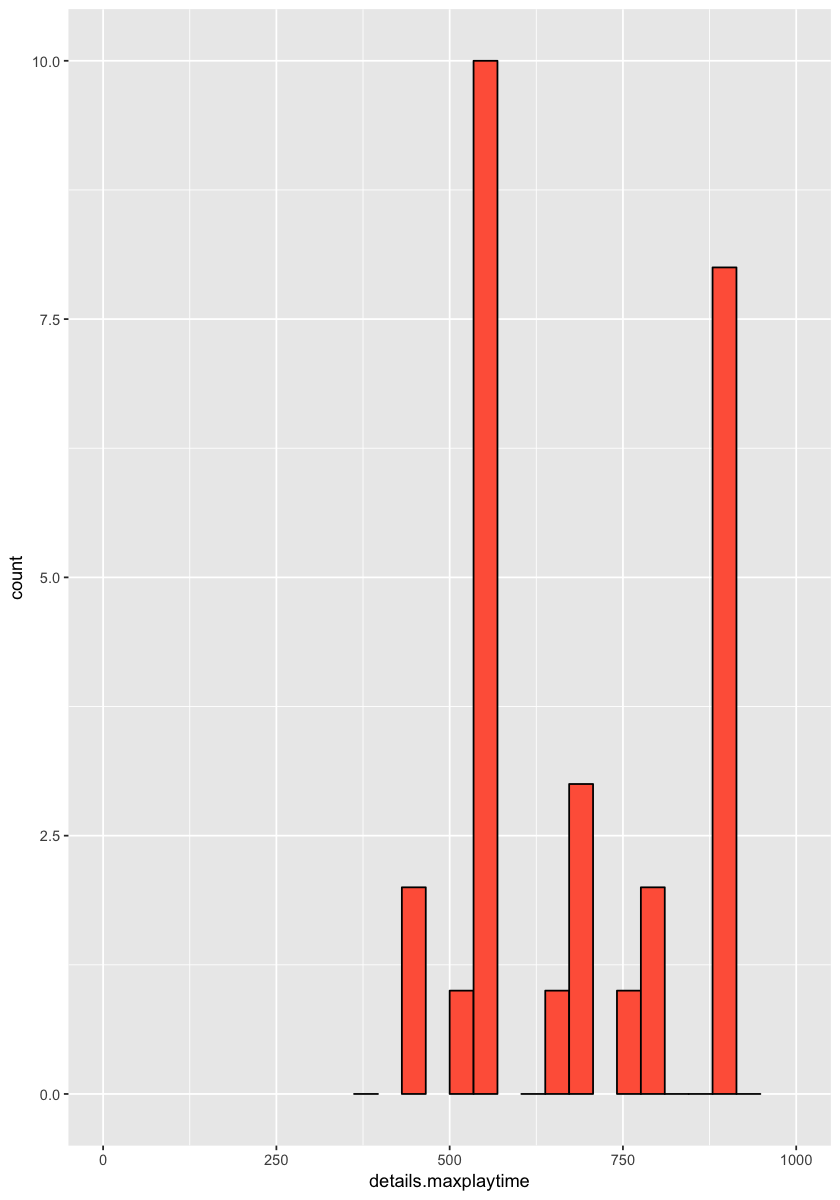

In [113]:
df %>%
filter(details.maxplaytime > 0) %>%
ggplot(aes(details.maxplaytime))+
geom_histogram(fill = "tomato", color = "black")+
ylim(0, 10)+
xlim(0, 1000)

## **Text Analysis of Board Games' Description**

In [181]:
# generate a function to analyse corpus text
analyseText = function(text_to_analyse){
    # analyse text and generate matrix of words
    # Returns a dataframe containing 1 tweet per row, one word per column
    # and the number of times the word appears per tweet
    CorpusTranscript = VCorpus(VectorSource(text_to_analyse))
    CorpusTranscript = tm_map(CorpusTranscript, content_transformer(tolower), lazy = T)
    CorpusTranscript = tm_map(CorpusTranscript, PlainTextDocument, lazy = T)
    CorpusTranscript = tm_map(CorpusTranscript, removePunctuation)
    CorpusTranscript = tm_map(CorpusTranscript, removeWords, stopwords("english"))
    CorpusTranscript = DocumentTermMatrix(CorpusTranscript)
    CorpusTranscript = removeSparseTerms(CorpusTranscript, 0.97) # keeps a matrix 97% sparse
    CorpusTranscript = as.data.frame(as.matrix(CorpusTranscript))
    colnames(CorpusTranscript) = make.names(colnames(CorpusTranscript))
    rownames(CorpusTranscript) = make.names(seq(1, 76688, by = 1))
    
    return(CorpusTranscript)
}

In [182]:
df_only_boardgames <- df %>%
filter(game.type == "boardgame")

game_text <- analyseText(df_only_boardgames$details.description)

In [183]:
dim(game_text)

[1] 76688   285

In [185]:
wordcloud(freq = as.vector(game_text), words = names(game_text), random.order = FALSE,
          random.color = FALSE, check.rows = FALSE, colors = brewer.pal(9, 'Reds')[4:9])

ERROR: Error in `[.data.frame`(freq, ord <= max.words): undefined columns selected


In [82]:
glimpse(df)

Observations: 90,400
Variables: 12
$ game.id               <chr> "1", "10", "1000", "10000", "100000", "100004...
$ game.type             <chr> "boardgame", "boardgame", "boardgame", "board...
$ details.description   <chr> "Die Macher is a game about seven sequential ...
$ details.maxplayers    <int> 5, 6, 10, 4, 0, 0, 0, 6, 4, 4, 12, 0, 6, 4, 4...
$ details.maxplaytime   <int> 240, 60, 45, 10, 0, 0, 0, 0, 20, 0, 0, 30, 30...
$ details.minage        <int> 14, 10, 12, 7, 8, 0, 0, 5, 6, 6, 0, 8, 6, 8, ...
$ details.minplayers    <int> 3, 2, 2, 2, 5, 3, 3, 2, 2, 1, 2, 4, 3, 2, 2, ...
$ details.minplaytime   <int> 240, 60, 45, 10, 0, 0, 0, 0, 20, 0, 0, 30, 30...
$ details.name          <chr> "Die Macher", "Elfenland", "Corona", "Roll an...
$ details.playingtime   <int> 240, 60, 45, 10, 0, 0, 0, 0, 20, 0, 0, 30, 30...
$ details.yearpublished <int> 1986, 1998, 1974, 1977, 1890, 1920, 1975, 199...
$ topic                 <chr> "Monopoly-inspired", "Modern Card Games", "Cl...
